Content Image:


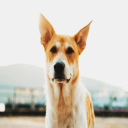

Style Image:


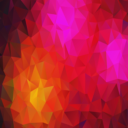

  0%|          | 0/3000 [00:00<?, ?it/s]

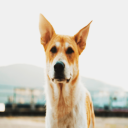

  3%|▎         | 100/3000 [01:33<44:34,  1.08it/s]

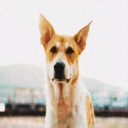

  7%|▋         | 200/3000 [03:07<42:03,  1.11it/s]  

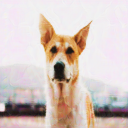

 10%|█         | 300/3000 [04:47<47:56,  1.07s/it]

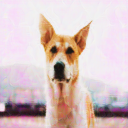

 13%|█▎        | 400/3000 [06:22<39:18,  1.10it/s]

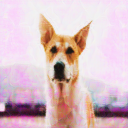

 17%|█▋        | 500/3000 [07:55<39:57,  1.04it/s]

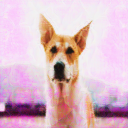

 20%|██        | 600/3000 [09:27<37:33,  1.07it/s]

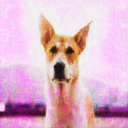

 23%|██▎       | 700/3000 [11:04<36:39,  1.05it/s]

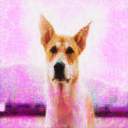

 27%|██▋       | 800/3000 [12:45<34:15,  1.07it/s]

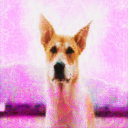

 30%|███       | 900/3000 [14:24<31:57,  1.10it/s]

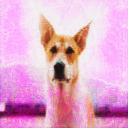

 33%|███▎      | 1000/3000 [16:02<31:16,  1.07it/s]

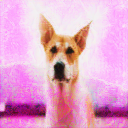

 37%|███▋      | 1100/3000 [17:40<38:56,  1.23s/it]

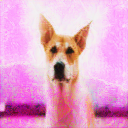

 40%|████      | 1200/3000 [19:38<28:14,  1.06it/s]  

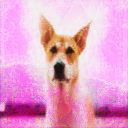

 43%|████▎     | 1300/3000 [21:19<28:05,  1.01it/s]

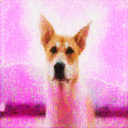

 47%|████▋     | 1400/3000 [22:53<26:09,  1.02it/s]

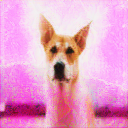

 50%|█████     | 1500/3000 [24:29<21:58,  1.14it/s]

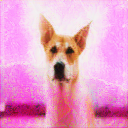

 53%|█████▎    | 1600/3000 [48:14<18:37:27, 47.89s/it]  

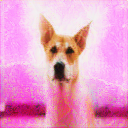

 57%|█████▋    | 1700/3000 [2:54:56<20:04,  1.08it/s]     

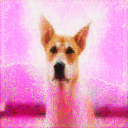

 60%|██████    | 1800/3000 [3:00:47<43:17,  2.16s/it]   

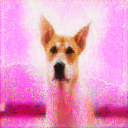

 63%|██████▎   | 1900/3000 [3:02:34<18:19,  1.00it/s]

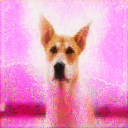

 67%|██████▋   | 2000/3000 [3:04:08<14:51,  1.12it/s]

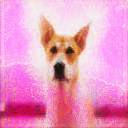

 70%|███████   | 2100/3000 [3:05:41<13:47,  1.09it/s]

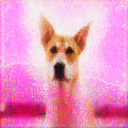

 73%|███████▎  | 2200/3000 [3:07:17<12:29,  1.07it/s]

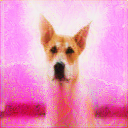

 77%|███████▋  | 2300/3000 [3:08:51<10:36,  1.10it/s]

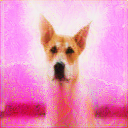

 80%|████████  | 2400/3000 [3:10:27<11:51,  1.19s/it]

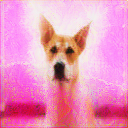

 83%|████████▎ | 2500/3000 [3:12:30<07:41,  1.08it/s]

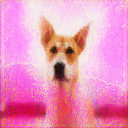

 87%|████████▋ | 2600/3000 [3:14:27<06:56,  1.04s/it]

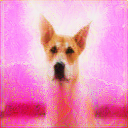

 90%|█████████ | 2700/3000 [3:16:20<05:35,  1.12s/it]

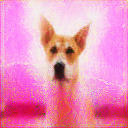

 93%|█████████▎| 2800/3000 [3:18:10<04:10,  1.25s/it]

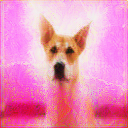

 97%|█████████▋| 2900/3000 [3:20:29<02:37,  1.57s/it]

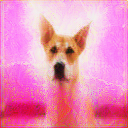

100%|██████████| 3000/3000 [3:23:35<00:00,  4.07s/it]


In [20]:
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
from tqdm import tqdm

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
imsize = 224 if torch.cuda.is_available() else 128  # use small size if no GPU

class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.chosen_features = ["0", "5", "10", "19", "28"]
        self.model = models.vgg19(pretrained=True).features[:29].eval()  # pretrained model
    
    def forward(self, x):
        features = []  # list of features
        for layer_num, layer in enumerate(self.model):
            x = layer(x)  # forward pass
            if str(layer_num) in self.chosen_features:  # if layer is in chosen features
                features.append(x)
        return features
    
class SoftClamp(nn.Module):
    def forward(self, image):
        return (torch.tanh(3 * image - 1.5) + 1) / 2.0

# Preprocessing and Deprocessing
def load_image(file_path):
    image = Image.open(file_path).convert("RGB")  # Open image and ensure it's RGB
    image = loader(image).unsqueeze(0)  # add the batch dimension
    return image.to(device)  # use GPU if available

def save_image(tensor, file_name):
    folder = "/Users/samarthuday/Desktop/Git/Art_Style/images/generated/"
    os.makedirs(folder, exist_ok=True)  # Create the folder if it doesn't exist
    file_path = os.path.join(folder, file_name)  # Full path for the file
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)  # remove the fake batch dimension
    image = unloader(image)  # convert tensor to PIL image
    image.save(file_name)
    print(f"Image saved at: {file_path}")

def show_image(tensor):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)  # remove the fake batch dimension
    image = unloader(image)  # convert tensor to PIL image
    display(image)
    # Convert PIL image to NumPy array for plotting
    #return np.array(image)

# Image transformations (similar to PyTorch approach)
loader = transforms.Compose([
    transforms.Resize((imsize, imsize)),  # resize image
    transforms.ToTensor(),  # convert image to Tensor
])

unloader = transforms.Compose([
    SoftClamp(),  # clamp image values for better visualization
    transforms.ToPILImage()  # convert Tensor to PIL Image
])

# Function to calculate Gram matrix for style loss
def gram_matrix(tensor):
    batch_size, channel, height, width = tensor.size()
    features = tensor.view(channel, height * width)
    G = torch.mm(features, features.t())  # Gram matrix
    return G / (channel * height * width)

# Load images
content_file = "/Users/samarthuday/Desktop/Git/Art_Style/content/dog.png" 
style_file = "/Users/samarthuday/Desktop/Git/Art_Style/style/ab4.jpeg" 

content_img = load_image(content_file)  # 1x3 x img_size x img_size tensor
style_img = load_image(style_file)  # 1x3 x img_size x img_size tensor

# Display the content and style images
print("Content Image:")
show_image(content_img)

print("Style Image:")
show_image(style_img)

# Initialize generated image (start with content image)
generated_img = content_img.clone()  # Initialize generated image as content image
generated_img.requires_grad_(True)  # Enable gradient computation

# Hyperparameters
total_steps = 3000  # Total number of steps for optimization
lr = 0.0005  # Learning rate
alpha = 1  # Weight for content loss
beta = 0.1  # Weight for style loss
optimizer = torch.optim.Adam([generated_img], lr=lr)

vgg = VGG().to(device)  # Pretrained VGG19 model

# Get style and content features
content_features = vgg(content_img)
style_features = vgg(style_img)

# Store images for visualization after training
stored_images = []

# Training loop
for step in tqdm(range(total_steps)):
    generated_img_features = vgg(generated_img)  # Features of generated image
    content_img_features = vgg(content_img)
    style_img_features = vgg(style_img)

    style_loss = content_loss = 0
    # Loop through all the features
    for gen_feature, content_feature, style_feature in zip(generated_img_features, content_img_features, style_img_features):
        
        batch_size, channel, height, width = gen_feature.shape  # Batch size = 1
        content_loss += torch.mean((gen_feature - content_feature) ** 2)  # Content loss

        # Compute Gram Matrix
        G = gen_feature.view(channel, height * width).mm(gen_feature.view(channel, height * width).t())
        A = style_feature.view(channel, height * width).mm(style_feature.view(channel, height * width).t())
        style_loss += torch.mean((G - A) ** 2)  # Style loss
    
    total_loss = alpha * content_loss + beta * style_loss  # Total loss
    optimizer.zero_grad()
    total_loss.backward()  # Backpropagate the loss
    optimizer.step()  # Update the image

    if step % 100 == 0:
        show_image(generated_img)  # Show the generated image every 100 steps
        
# Get the name of latest generated image
save_image(generated_img, "generated2.png")
